## <h1><center>Time Series stock value predictor</center></h1>

<a id="indice"></a> 
## Index

### <a href='#section_objetivos'>0. Objectives of this work</a>


### <a href='#section_introduccion'>1. Detailed work</a>
- #### <a href='#1.1'>1.1 Imports</a>
- #### <a href='#1.2'>1.2 Creation of the needed functions</a>
- #### <a href='#1.3'>1.3 Creation of the nasted function to make full predictions</a>


### <a href='#2.'>2. Example</a>
- #### <a href='#2.1'>2.1 Creating a Data variable in which to store the function outputs</a>
- #### <a href='#2.2'>2.2 Outputs</a>

### <a href='#3.'>3 Conclusions</a>

### <a href='#4.'>4 Future Steps</a>

<a id="section_objetivos"></a> 
## 0. Objectives of this work
<a href='#indice'>Back to index</a>

This work will inted to achive a stock value prediction for further days/months comparing between several Arima time series models and parameters to select the best one.
It will gather as input a stock/financial asset symbol, the interval and also the date from wich to do the predictions (it will use the actual date if this value is not given)
As output, we will return different graphs to analyse the data and time series decomposition, the results dataframe wich gives a complete analysis of each model, a predictions graph. As aditional info we will include in the results differents dataframes if the user wants to see more details.

Enjoy!!

<a id="section_introduccion"></a> 
## 1. Detailed Work
<a href='#indice'>Back to Index</a>

<a id="1.1"></a> 
## 1.1 Imports
<a href='#indice'>Back to Index</a>

First of all we need to get all the libraries that we will use. The next three lines will be commented, but some of this libraries is not actualized in your enviroment, you must install it.

In [ ]:
#!pip install --upgrade pandas --user

In [2]:
#!pip install --upgrade pandas-datareader --user

In [3]:
#!pip install --upgrade mplfinance --user

Following step is to import all other libraries that we will use.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from datetime import timedelta

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

import mplfinance as mpf

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import plotly.subplots as ms
import plotly.graph_objects as go


<a id="1.2"></a> 
## 1.2 Creation of the needed functions
<a href='#indice'>Back to Index</a>

In the next section we will create different functions that will be a must for the creation of a nasted function.
This function will be separated as follows:
- Gather data
- Graph data
- Seasonality - dummies
- Results DataFrame creation
- Separating data into train and test DataFrames
- Developing the models and select wich is best
- Metrics
- Callecting all the values in a unique dataframe
- Graph predictions

In [5]:
# Function captura_datos, connects to yahoo finance data and querys the info for the choosen parameters.
# Creates a new DataFrame.
# Also calculates 5 and 20 periods mooving averages
# Finally adds rows to the dataframe depending on the choosen interval. This will be used in the future to inserts predictions and graph the data.
# The output will be the dataframe

def captura_datos (activo,end,interval):
    tipo = 0
    #yf.pdr_override()
    #start = datetime.datetime.strptime(start,'%Y-%m-%d')
    end = datetime.datetime.strptime(end,"%Y, %m, %d" )
    #end = datetime.datetime.now() #esto es para cuando el código corre fluido a partir de la fecha
    if interval =="d":
        start = end - BDay(280) #esto es para definir 1 año a partir de la fecha, lo uso para pruebas del código.
    else:
        start = end - BDay(800)
    df = web.get_data_yahoo(activo, start, end, interval=interval)
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
    df["date"] = df.index
    df = df.reset_index()
    if interval=="d":
        for i in range (15):
            x = len(df)
            df.loc[x] = np.nan
            y=x-1
            df.loc[x,"timeIndex"] = df.timeIndex[y] + 1
            df.date[x] = df.date[y] + BDay(1)
    else:
        for i in range (3):
            x = len(df)
            y=x-1
            df.loc[x] = np.nan
            df.loc[x,"timeIndex"] = df.timeIndex[y] + 1
            df.date[x] = df.date[y] + relativedelta(months=1)

    df = df.set_index("date")
    return df     

# Function graficar_datos will decompose the real data series in trend, seasonal and residuals and show the graphs. It will use the additive model of a seasonal_decompose of statsmodels
# It will also make a interactive graph to show the data and the mooving averages.

def graficar_datos(df):
    # genero los gráficos con la serie de tiempo, la estacionalidad y el componente aleatorio
    plt.figure()
    plt.rcParams.update({'figure.figsize': (15,10)})
    y=pd.DataFrame(df.Close.dropna())
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq=12)
    decomposition.plot()
    plt.show()
    
    # grafico la serie de tiempo, medias moviles y volumen
    #mpf.plot(df,type='candle',mav=(3,6,9),volume=True,style='yahoo',figratio=(11,8),figscale=2)
    
    # Dibuja gráfico interactivo con plotly
    #Make Subplot of 2 rows to plot 2 graphs sharing the x axis
    fig1 = ms.make_subplots(rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0)

    #Add Candlstick Chart to Row 1 of subplot
    fig1.add_trace(go.Scatter(x=df.index, 
                         y=df['MA5'], 
                         opacity=0.7, 
                         line=dict(color='blue', width=1), 
                         name='MA 5'))
    fig1.add_trace(go.Scatter(x=df.index, 
                         y=df['MA20'], 
                         opacity=0.7, 
                         line=dict(color='orange', width=1), 
                         name='MA 20'))
    fig1.add_trace(go.Candlestick(x = df.index,
    low = df["Low"],
    high = df["High"],
    close = df["Close"],
    open = df["Open"],
    increasing_line_color = "green",
    decreasing_line_color = "red"),
    row=1,
    col=1)

    #Add Volume Chart to Row 2 of subplot
    colors = ['red' if row['Open'] - row['Close'] >= 0 
          else 'green' for index, row in df.iterrows()]
    fig1.add_trace(go.Bar(x=df.index, 
                     y=df['Volume'],
                     marker_color=colors
                    ), row=2, col=1)


    #Update Price Figure layout
    fig1.update_layout(title = "Interactive CandleStick & Volume Chart",
    yaxis1_title = "Stock Price ($)",
    yaxis2_title = "Volume (M)",
    xaxis2_title = "Time",width=910, height=600)
    fig1['layout']['yaxis1'].update(domain=[0.2,1])
    fig1['layout']['yaxis2'].update(domain=[0,0.2])

    #Agregar botones
    fig1.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
    buttons=list([
    dict(count=3, label="trim", step="month", stepmode="backward"),
    dict(count=6, label="semes", step="month", stepmode="backward"),
    dict(count=1, label="1 year", step="year", stepmode="backward"),
    #dict(count=5, label="5 years", step="year", stepmode="backward"),
    dict(step="all")
    ])
    ),
    row=1, col=1)
    fig1.show("png")


# Function seasonality will add new columns for the date's dummies: Month and weekday.
# The output will be the dataframe, the column names as string and as a list. Last two outputs will be used as input of the different Arima models


def seasonality(df,interval):
    if interval=="m":
        df["month"]= (df.index + datetime.timedelta(days=1)).strftime('%b')
    else:
        df['month'] = df.index.strftime('%b')
    dummies = pd.get_dummies(df['month'],drop_first=True)
    if interval=="d":
        df['weekday']= df.index.strftime("%A")
        dummies_dia = pd.get_dummies(df['weekday'],drop_first=True)
        dummies = dummies.join(dummies_dia)
    dummies_col = dummies.columns
    df["log_value"]  = np.log(df['Close'])
    df["timeIndex_sq"] = df["timeIndex"]**2
    df = df.join(dummies)
    string = ""
    for i in range(len(dummies.columns)):
        x = str(dummies.columns[i])
        if i ==0:
            string += x
        else:
            string += " + "+x
    return (df,string,dummies_col)


# Function creacion_results will create a Dataframe with the columns needed to compare different models
# And will complete some of the ranges of the DataFrame with info of the different Arima models
# The output will be the Results DataFrame

def creacion_results(data,activo,end):
    # creo el dataframe Results donde voy a poner toda la info de cada modelo y finalmente presentar si son estacionarios o no
    Nombre = ["lineal","lineal","log","log","quad","quad"]
    Est = ["Est","No_Est","Est","No_Est","Est","No_Est"]
    string = [""]
    Results = pd.DataFrame(columns=["Activo","inicio","Nombre_modelo","Nombre","Est","string","listxpred","Modelo","p_value","Serie_estacionaria?","nombre_residuos","RMSE_train","RMSE_test","p","q","d","modelo_arima","RMSE_test_scl","dif_porcentual_pred_vs_real","close_real","fecha_real","close_pred","max_pred","ganancia_porcentual_pred","ganancia_porcentual_pred_vs_close_real"])
    Results["Nombre"] = Nombre
    Results["Est"] = Est

    #con este for armo strings para poder poner en la función para fitear el modelo y listas para poder poner en la función de predecir el modelo
    for i in range(len(Results)):
        lista1=["timeIndex"]
        lista2=["timeIndex","timeIndex_sq"]
        Results["Activo"] = activo
        Results["inicio"] = end
        if Nombre[i] == 'lineal':
            if Est[i] =="Est":
                Results["string"][i] = 'Close ~ timeIndex' + ' + ' + data[1]
                for x in range(len(data[2])):
                    lista1.append(data[2][x])
                Results["listxpred"][i]=lista1
            else:
                Results["string"][i] = 'Close ~ timeIndex' 
                Results["listxpred"][i]=lista1
        elif Nombre[i] == 'log':
            if Est[i] =="Est":
                Results["string"][i] = 'log_value ~ timeIndex' + ' + ' + data[1]
                for x in range(len(data[2])):
                    lista1.append(data[2][x])
                Results["listxpred"][i]=lista1
            else:
                Results["string"][i] = 'log_value ~ timeIndex'
                Results["listxpred"][i]=lista1
        elif Nombre[i] == 'quad':
            if Est[i] =="Est":
                Results["string"][i] = 'Close ~ timeIndex + timeIndex_sq' + ' + ' + data[1]
                for x in range(len(data[2])):
                    lista2.append(data[2][x])
                Results["listxpred"][i]=lista2
            else:
                Results["string"][i] = 'Close ~ timeIndex + timeIndex_sq'
                Results["listxpred"][i]=lista2
    
    return (Results)


# Function train_test will receive the complete dataset for the stock chosen, the Results Dataframe and the interval
# will create the train and test dataset. Test size will depend on the chosen interval.
# For each row in the dataframe Results will make a different model (linear, quadratic or logaritmic), calculate predictions and its residuals
# With each model it will instance the adfuller function just to know if the model represents a stationary series and can be suitable for arima models.
# Furtheron, it will complete all the details in the Results Dataframe thet will be used to calculate predictions for arima models
# Also, this function will return as output de train and test dataframe


def train_test(data,Results,interval):
    #creo los dataframes de train y test. El test size debería ser estático: 6 si es en meses y 15 si son en días.
    if interval=="d":
        ts= 30
    else:
        ts=6
    df_train, df_test = train_test_split(data[0], test_size=ts, random_state=42, shuffle=False)

    #itero por cada renglon del dataframe results para crear el modelo y fitearlo, predecir los valores del modelo y calcular los residuos en cada caso.
    #todos los datos los grabo en el df_train
    # también grabo el modelo en el dataframe Results
    # analizo si la serie de residuos es estacionaria y grabo el resultado en el df Results

    #creo lista de columnas para construir dataframe final
    lista_columnas = ["Close"]

    for i in range(len(Results.index)):
        nombre_modelo = Results.Nombre[i] + " + " + Results.Est[i]
        modelo = smf.ols(Results.string[i], data = df_train).fit()
        Results.Nombre_modelo[i] = nombre_modelo
        Results.Modelo[i] = modelo
        df_train[nombre_modelo] = modelo.predict(df_train[Results.listxpred[i]])      
        df_test[nombre_modelo] = modelo.predict(df_test[Results.listxpred[i]])
        nombre_residuo = "Residuos" + nombre_modelo
        Results.nombre_residuos[i] = nombre_residuo
        if Results.Nombre[i] == "log":
            df_train["back"+nombre_modelo] = np.exp(df_train[nombre_modelo])
            df_test["back"+nombre_modelo] = np.exp(df_test[nombre_modelo])
            df_train[nombre_residuo] = df_train['Close'] - df_train["back"+nombre_modelo]
            Results.Nombre_modelo[i] = "back"+nombre_modelo
        else:
            df_train[nombre_residuo] = df_train['Close'] - df_train[nombre_modelo]
        result = adfuller(df_train[nombre_residuo])
        Results.p_value[i] = result[1]
        if result[1]<0.05:
            Results["Serie_estacionaria?"][i] = "Si"
            nombre2="pred_ARIMA"+Results.Nombre_modelo[i]
            lista_columnas.append(nombre2)
        else:
            Results["Serie_estacionaria?"][i] = "No"
            
    return (Results,lista_columnas,df_train,df_test)


# CV function will make a loop in the Results dataframe and make the Arima model to each model that where Arima is suitable.
# If the residuals of a model is not stationary this function will pass to do the Arima model of the residuals.
# If the data series is suitable to do the Arima model, the function will make a loop with different values of p,d,q variables of the model. 
# It will calculate RMSE value for each dataframe (train and test) and will select wich of the variables suits best.
# Arima model in statsmodels doesn't support gridsearch, so doing this function will do so in a loop process.
# Finally, this function will complete each row of the Results dataframe with the info of the variables (p,d,q) and the RMSE values for test and train.

def CV(Results,df_train,df_test):
    numbers=5
    long_test = df_test.shape[0]
    long_test_null = df_test["Close"].isnull().sum()
    long_test_RMSE = long_test - long_test_null
    for i in range(len(Results.index)):
        if Results["Serie_estacionaria?"][i]=="Si":
            for d in range(0,numbers):
                for p in range(1,numbers):
                    for q in range(1,numbers):
                        order=(p,d,q)
                        try:
                            model_ARIMA = ARIMA(df_train[Results.nombre_residuos[i]],order=(p,d,q))
                            results_ARIMA = model_ARIMA.fit()
                            pred_train = results_ARIMA.fittedvalues
                            predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test), alpha=0.05)
                            pred_close_train = df_train[Results.Nombre_modelo[i]] + pred_train
                            pred_close_test = df_test[Results.Nombre_modelo[i]] + predictions_ARIMA                        
                            RMSE_train = RMSE(pred_close_train,df_train["Close"])
                            RMSE_test = RMSE(pred_close_test[0:long_test_RMSE],df_test["Close"][0:long_test_RMSE])
                            if order == (1,0,1):
                                RMSE_value= RMSE_test
                                RMSE_train_value = RMSE_train
                                p_modelo=p
                                d_modelo=d
                                q_modelo=q
                            elif RMSE_test<RMSE_value:
                                RMSE_value= RMSE_test
                                RMSE_train_value = RMSE_train
                                p_modelo=p
                                d_modelo=d
                                q_modelo=q
                        except:
                            continue
            Results.p[i] = p_modelo
            Results.d[i] = d_modelo
            Results.q[i] = q_modelo
            Results.RMSE_train[i] = RMSE_train_value
            Results.RMSE_test[i] = RMSE_value
            Results.modelo_arima[i] = ARIMA(df_train[Results.nombre_residuos[i]],order=(p_modelo,d_modelo,q_modelo)).fit()
            df_train["pred_ARIMA"+Results.Nombre_modelo[i]] = df_train[Results.Nombre_modelo[i]] + Results.modelo_arima[i].fittedvalues
            df_test["pred_ARIMA"+Results.Nombre_modelo[i]] = df_test[Results.Nombre_modelo[i]] + Results.modelo_arima[i].forecast(len(df_test), alpha=0.05)[0]

    return(Results,df_train,df_test,long_test_RMSE)    

# RMSE formula will calculate the Root mean Squared error of each model

def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

# calculo_resultados will add more info al DataFrame Results.
# This function will create a dataframe with the real value and the predictions of each Arima model
# Later it will scale those values and calculate the scaled RMSE (this will be used as a comparison metric between models)
# Furthermore, it will calculate different values wich are important to make an invest decision (% of difference, estimated results of the inversion, etc)

def calculos_resultados(df_test,lista_columnas,Results):
    aaa = df_test[lista_columnas]
    long_test = df_test.shape[0]
    long_test_null = df_test["Close"].isnull().sum()
    long_test_RMSE = long_test - long_test_null
    
    scaler = StandardScaler()
    aaa_scl = pd.DataFrame(scaler.fit_transform(aaa[0:long_test_RMSE]),columns=aaa.columns)

    for i in range(Results.shape[0]):
        if Results["Serie_estacionaria?"][i] =="Si":
            long_test = df_test.shape[0]
            long_test_null = df_test["Close"].isnull().sum()
            long_test_RMSE = long_test - long_test_null
            valor = RMSE(aaa_scl["pred_ARIMA"+Results.Nombre_modelo[i]][0:long_test_RMSE],aaa_scl.Close[0:long_test_RMSE])
            Results["RMSE_test_scl"][i] = valor
            Results["dif_porcentual_pred_vs_real"][i] = (aaa["pred_ARIMA"+Results.Nombre_modelo[i]][long_test_RMSE-1]-aaa.Close[long_test_RMSE-1])/aaa.Close[long_test_RMSE-1]*100
            Results["close_pred"][i] = aaa["pred_ARIMA"+Results.Nombre_modelo[i]][long_test_RMSE-1]
            Results["max_pred"][i] = aaa["pred_ARIMA"+Results.Nombre_modelo[i]][long_test_RMSE:aaa.shape[0]].max()
            Results["ganancia_porcentual_pred"][i] = (Results["max_pred"][i]-Results["close_pred"][i])/Results["close_pred"][i]*100
            Results["close_real"][i] = aaa.Close[long_test_RMSE-1]
            Results["fecha_real"][i] = aaa.index[long_test_RMSE-1]
            Results["ganancia_porcentual_pred_vs_close_real"][i] = (Results["max_pred"][i]-Results["close_real"][i])/Results["close_real"][i]*100
            
    
    Results = Results.sort_values(by="RMSE_test",ascending=True)
    return(aaa,aaa_scl,Results)

# graficar_predicciones_arima will graph all the time series of test dataframe: real one (close value) and the predicted ones in each Arima model
# also it will predict future values

def graficar_predicciones_arima(data):
    color = ["blue","green","red","violet","yellow","pink","black"]
    j=-1
    fig = ms.make_subplots(rows=1,cols=1)
    for i in data.columns:
        if data[i].isnull().sum() != data.shape[0]:
            j+=1
            try:
                fig.add_trace(go.Scatter(x=data.index, 
                             y=data[i], 
                             opacity=0.7, 
                             line=dict(color=color[j], width=1), 
                             name=i))
            except:
                    continue
    fig.update_layout(title = "Gráfico de Predicciones vs Real",
    yaxis_title = "($)Precio de Cierre",
    xaxis_title = "Time",width=910, height=600)
    fig.update_xaxes(rangeslider=dict(
            visible=True,
            #range=(dates[0], dates[-1])
        ))
    return(fig.show("png"))

<a id="1.3"></a> 
## 1.3 Creation of the nasted function to make full predictions
<a href='#indice'>Back to Index</a>

The next function will join the functions created in 1.2 and make a complete process.

Warning: This process can last 5/10 minutes depending on the quantity of models that can make.

In [6]:
def price_prediction(activo,interval,end = datetime.datetime.strftime(datetime.datetime.today(),"%Y, %m, %d")):
    data = captura_datos(activo,end,interval)
    graficar_datos(data)
    data = seasonality(data,interval)
    Resultados = creacion_results(data,activo,end)
    Results,lista_columnas,df_train,df_test = train_test(data,Resultados,interval)
    CV(Results,df_train,df_test)
    Resultados = calculos_resultados(df_test,lista_columnas,Results)
    display(Resultados[2])
    graficar_predicciones_arima(Resultados[0])
    return (data[0],data[1],data[2],Resultados[0],Resultados[1],Resultados[2],lista_columnas,df_train,df_test)

<a id="2."></a> 
## 2. Example
<a href='#indice'>Back to Index</a>

<a id="2.1"></a> 
## 2.1 Creating a Data variable in which to store the function outputs
<a href='#indice'>Back to Index</a>

We will collect all the function outputs in the variable "data".
In this example we will call the function for the symbol "BTC-USD" in a daily period starting from today.

Running the function, it will display some graphs about the data, the Results DataFrame to compare all models data and finally the graph where we can see the price predictions for each Arima model.  

<Figure size 432x288 with 0 Axes>

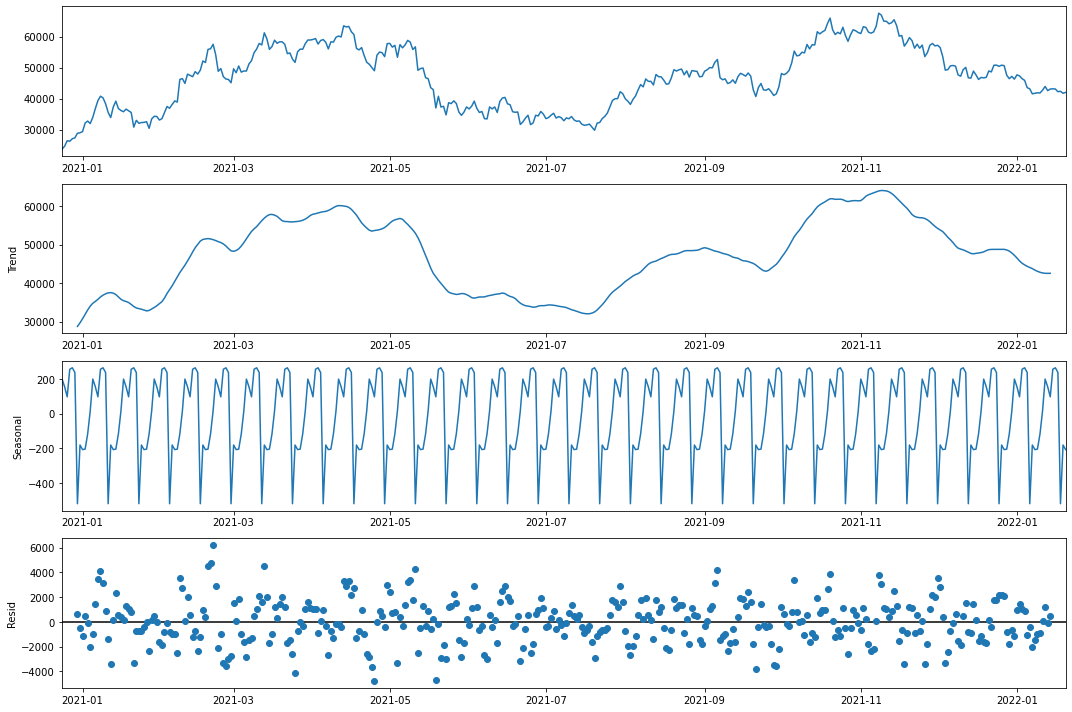

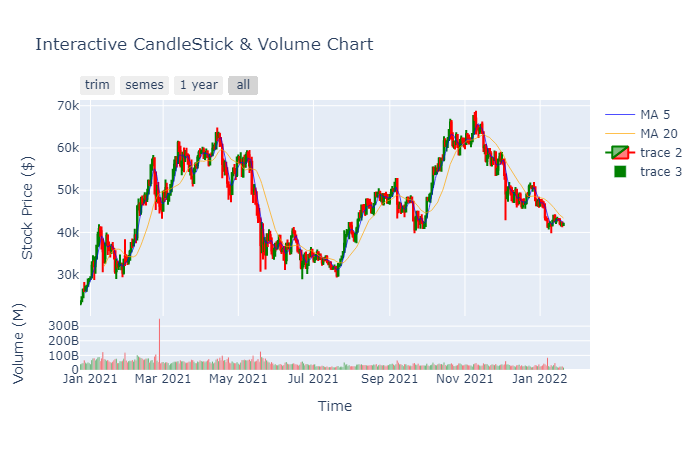

,Activo,inicio,Nombre_modelo,Nombre,Est,string,listxpred,Modelo,p_value,Serie_estacionaria?,...,d,modelo_arima,RMSE_test_scl,dif_porcentual_pred_vs_real,close_real,fecha_real,close_pred,max_pred,ganancia_porcentual_pred,ganancia_porcentual_pred_vs_close_real
2,btc-usd,"2022, 1, 20",backlog + Est,log,Est,log_value ~ timeIndex + Aug + Dec + Feb + Jan ...,"[timeIndex, Aug, Dec, Feb, Jan, Jul, Jun, Mar,...",<statsmodels.regression.linear_model.Regressio...,1.947e-07,Si,...,2,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.35095,-0.269569,42029.8,2022-01-20 00:00:00,41916.5,58634.4,39.8837,39.5066
0,btc-usd,"2022, 1, 20",lineal + Est,lineal,Est,Close ~ timeIndex + Aug + Dec + Feb + Jan + Ju...,"[timeIndex, Aug, Dec, Feb, Jan, Jul, Jun, Mar,...",<statsmodels.regression.linear_model.Regressio...,8.69869e-06,Si,...,2,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.39423,0.898589,42029.8,2022-01-20 00:00:00,42407.5,52730.4,24.342,25.4594
4,btc-usd,"2022, 1, 20",quad + Est,quad,Est,Close ~ timeIndex + timeIndex_sq + Aug + Dec +...,"[timeIndex, timeIndex_sq, Aug, Dec, Feb, Jan, ...",<statsmodels.regression.linear_model.Regressio...,8.472e-06,Si,...,1,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.37977,1.12875,42029.8,2022-01-20 00:00:00,42504.3,49567,16.6166,17.9329
1,btc-usd,"2022, 1, 20",lineal + No_Est,lineal,No_Est,Close ~ timeIndex,[timeIndex],<statsmodels.regression.linear_model.Regressio...,0.188933,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,btc-usd,"2022, 1, 20",backlog + No_Est,log,No_Est,log_value ~ timeIndex,[timeIndex],<statsmodels.regression.linear_model.Regressio...,0.200032,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,btc-usd,"2022, 1, 20",quad + No_Est,quad,No_Est,Close ~ timeIndex + timeIndex_sq,"[timeIndex, timeIndex_sq]",<statsmodels.regression.linear_model.Regressio...,0.182782,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


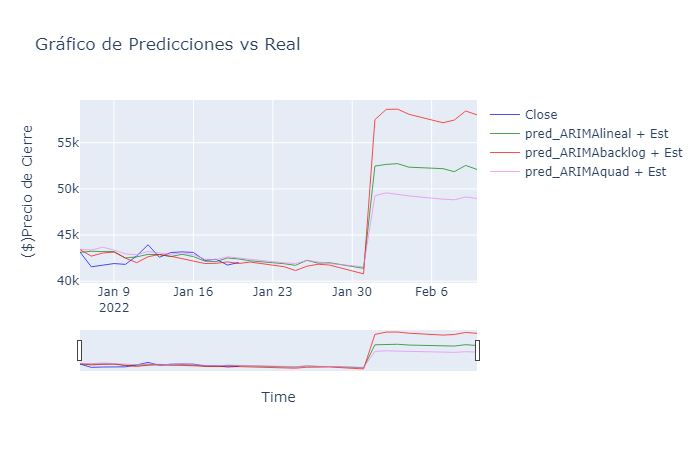

In [7]:
data = price_prediction("btc-usd","d","2022, 1, 20")

<a id="2.2"></a> 
## 2.2 Outputs
<a href='#indice'>Back to Index</a>

There are 9 outputs for the function, I will explain each one

In [8]:
len(data)

9

data[0] is the complete DataFrame with the data taken from yahoo finance and arranges for seasonality dummies

In [9]:
data[0]

,Date,High,Low,Open,Close,Volume,Adj Close,MA20,MA5,timeIndex,...,May,Nov,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,2020-12-24,23768.337891,22777.597656,23240.203125,23735.949219,4.108076e+10,23735.949219,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1,0,0
2020-12-25,2020-12-25,24710.101562,23463.673828,23733.570312,24664.791016,4.206840e+10,24664.791016,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
2020-12-26,2020-12-26,26718.070312,24522.689453,24677.015625,26437.037109,4.833265e+10,26437.037109,NaN,NaN,2.0,...,0,0,0,0,0,1,0,0,0,0
2020-12-27,2020-12-27,28288.839844,25922.769531,26439.373047,26272.294922,6.647990e+10,26272.294922,NaN,NaN,3.0,...,0,0,0,0,0,0,1,0,0,0
2020-12-28,2020-12-28,27389.111328,26207.640625,26280.822266,27084.808594,4.905674e+10,27084.808594,NaN,25638.976172,4.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,403.0,...,0,0,0,0,0,0,0,0,0,0
2022-02-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404.0,...,0,0,0,0,1,0,0,0,0,0
2022-02-08,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405.0,...,0,0,0,0,0,0,0,0,1,0


data[1] is a string for the seasonality dummies titles and data[2] is a list containing the column titles

In [10]:
data[1]

'Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep + Monday + Saturday + Sunday + Thursday + Tuesday + Wednesday'

In [11]:
data[2]

Index(['Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

data[3] is the DataFrame containing the test values and predictions for all the models

In [12]:
data[3]

,Close,pred_ARIMAlineal + Est,pred_ARIMAbacklog + Est,pred_ARIMAquad + Est
date,,,,
2022-01-06,43160.929688,43124.575382,43416.548940,43469.503235
2022-01-07,41557.902344,43242.703649,42717.066973,43362.684512
2022-01-08,41733.941406,43207.629286,43049.945733,43683.319753
2022-01-09,41911.601562,43211.007007,43153.335612,43371.482324
2022-01-10,41821.261719,42518.997268,42495.026481,42958.270671
2022-01-11,42735.855469,42633.033478,42006.820666,42863.873530
2022-01-12,43949.101562,42909.356246,42647.422737,43217.199210
2022-01-13,42591.570312,42880.609808,42897.875183,43050.272261
2022-01-14,43099.699219,42660.348833,42703.312715,42903.391611


data[4] is a dataframe with the standarized test data and its predictions. Is usefull to compare between models

In [13]:
data[4]

,Close,pred_ARIMAlineal + Est,pred_ARIMAbacklog + Est,pred_ARIMAquad + Est
0,0.995612,1.077417,1.930564,1.264816
1,-1.360573,1.413099,0.448412,0.988536
2,-1.101824,1.313429,1.153758,1.817838
3,-0.840693,1.323028,1.372834,1.011291
4,-0.973478,-0.643440,-0.022075,-0.057453
5,0.370824,-0.319386,-1.056548,-0.301605
6,2.154095,0.465834,0.300841,0.612248
7,0.158748,0.384146,0.831532,0.180503
8,0.905614,-0.241765,0.419268,-0.199394
9,1.019819,0.483986,-0.142545,0.274212


data[5] is the Results dataframe

In [14]:
data[5]

,Activo,inicio,Nombre_modelo,Nombre,Est,string,listxpred,Modelo,p_value,Serie_estacionaria?,...,d,modelo_arima,RMSE_test_scl,dif_porcentual_pred_vs_real,close_real,fecha_real,close_pred,max_pred,ganancia_porcentual_pred,ganancia_porcentual_pred_vs_close_real
2,btc-usd,"2022, 1, 20",backlog + Est,log,Est,log_value ~ timeIndex + Aug + Dec + Feb + Jan ...,"[timeIndex, Aug, Dec, Feb, Jan, Jul, Jun, Mar,...",<statsmodels.regression.linear_model.Regressio...,1.947e-07,Si,...,2,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.35095,-0.269569,42029.8,2022-01-20 00:00:00,41916.5,58634.4,39.8837,39.5066
0,btc-usd,"2022, 1, 20",lineal + Est,lineal,Est,Close ~ timeIndex + Aug + Dec + Feb + Jan + Ju...,"[timeIndex, Aug, Dec, Feb, Jan, Jul, Jun, Mar,...",<statsmodels.regression.linear_model.Regressio...,8.69869e-06,Si,...,2,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.39423,0.898589,42029.8,2022-01-20 00:00:00,42407.5,52730.4,24.342,25.4594
4,btc-usd,"2022, 1, 20",quad + Est,quad,Est,Close ~ timeIndex + timeIndex_sq + Aug + Dec +...,"[timeIndex, timeIndex_sq, Aug, Dec, Feb, Jan, ...",<statsmodels.regression.linear_model.Regressio...,8.472e-06,Si,...,1,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,1.37977,1.12875,42029.8,2022-01-20 00:00:00,42504.3,49567,16.6166,17.9329
1,btc-usd,"2022, 1, 20",lineal + No_Est,lineal,No_Est,Close ~ timeIndex,[timeIndex],<statsmodels.regression.linear_model.Regressio...,0.188933,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,btc-usd,"2022, 1, 20",backlog + No_Est,log,No_Est,log_value ~ timeIndex,[timeIndex],<statsmodels.regression.linear_model.Regressio...,0.200032,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,btc-usd,"2022, 1, 20",quad + No_Est,quad,No_Est,Close ~ timeIndex + timeIndex_sq,"[timeIndex, timeIndex_sq]",<statsmodels.regression.linear_model.Regressio...,0.182782,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data[6] is just a list containing the titles of the columns of the test values and predictios dataframe (data[3] and data[4])

In [15]:
data[6]

['Close',
 'pred_ARIMAlineal + Est',
 'pred_ARIMAbacklog + Est',
 'pred_ARIMAquad + Est']

data[7] is the final train dataframe with all the columns used for the models.

In [16]:
data[7]

,Date,High,Low,Open,Close,Volume,Adj Close,MA20,MA5,timeIndex,...,log + No_Est,backlog + No_Est,Residuoslog + No_Est,quad + Est,Residuosquad + Est,quad + No_Est,Residuosquad + No_Est,pred_ARIMAlineal + Est,pred_ARIMAbacklog + Est,pred_ARIMAquad + Est
date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,2020-12-24,23768.337891,22777.597656,23240.203125,23735.949219,4.108076e+10,23735.949219,NaN,NaN,0.0,...,10.591280,39786.382182,-16050.432963,28871.858266,-5135.909048,41645.388280,-17909.439061,NaN,NaN,NaN
2020-12-25,2020-12-25,24710.101562,23463.673828,23733.570312,24664.791016,4.206840e+10,24664.791016,NaN,NaN,1.0,...,10.592032,39816.329274,-15151.538259,28953.052673,-4288.261657,41666.296582,-17001.505566,NaN,NaN,28951.456229
2020-12-26,2020-12-26,26718.070312,24522.689453,24677.015625,26437.037109,4.833265e+10,26437.037109,NaN,NaN,2.0,...,10.592785,39846.298908,-13409.261798,29396.423244,-2959.386135,41687.263908,-15250.226798,30913.220738,29984.513220,29387.695581
2020-12-27,2020-12-27,28288.839844,25922.769531,26439.373047,26272.294922,6.647990e+10,26272.294922,NaN,NaN,3.0,...,10.593537,39876.291099,-13603.996177,29411.077941,-3138.783019,41708.290256,-15435.995335,30550.907126,29597.371876,29387.335449
2020-12-28,2020-12-28,27389.111328,26207.640625,26280.822266,27084.808594,4.905674e+10,27084.808594,NaN,25638.976172,4.0,...,10.594290,39906.305866,-12821.497272,29187.521345,-2102.712752,41729.375629,-14644.567035,31282.559712,30595.604969,29127.176202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,2022-01-01,47827.312500,46288.484375,46311.746094,47686.812500,2.458267e+10,47686.812500,48140.353906,47040.989844,373.0,...,10.871930,52676.797676,-4989.985176,49600.039976,-1913.227476,53539.108312,-5852.295812,52580.747160,55026.440111,49556.631376
2022-01-02,2022-01-02,47881.406250,46856.937500,47680.925781,47345.218750,2.795157e+10,47345.218750,48170.740820,46992.262500,374.0,...,10.872683,52716.447346,-5371.228596,49378.834105,-2033.615355,53582.032331,-6236.813581,52105.918480,57618.409212,49371.426026
2022-01-03,2022-01-03,47510.726562,45835.964844,47343.542969,46458.117188,3.307163e+10,46458.117188,48163.015039,46994.943750,375.0,...,10.873435,52756.126860,-6298.009673,48919.416941,-2461.299753,53625.015374,-7166.898186,51463.747460,53056.744867,48976.002321


data[8] is the final test dataframe with all the columns used for the models.

In [17]:
data[8]

,Date,High,Low,Open,Close,Volume,Adj Close,MA20,MA5,timeIndex,...,lineal + No_Est,log + Est,backlog + Est,log + No_Est,backlog + No_Est,quad + Est,quad + No_Est,pred_ARIMAlineal + Est,pred_ARIMAbacklog + Est,pred_ARIMAquad + Est
date,,,,,,,,,,,,,,,,,,,,,
2022-01-06,2022-01-06,43748.718750,42645.539062,43565.511719,43160.929688,3.020805e+10,43160.929688,47656.175781,45286.168750,378.0,...,53045.939836,10.901319,54247.880336,10.875692,52875.344693,49062.755247,53754.318641,43124.575382,43416.548940,43469.503235
2022-01-07,2022-01-07,43153.570312,41077.445312,43153.570312,41557.902344,8.419661e+10,41557.902344,47391.632031,44128.705469,379.0,...,53077.944532,10.900289,54192.040567,10.876445,52915.143809,48903.638886,53797.537777,43242.703649,42717.066973,43362.684512
2022-01-08,2022-01-08,42228.941406,40672.277344,41561.464844,41733.941406,2.806636e+10,41733.941406,47142.978320,43183.870313,380.0,...,53109.949228,10.906050,54505.134952,10.877197,52954.972881,49106.698689,53840.815936,43207.629286,43049.945733,43683.319753
2022-01-09,2022-01-09,42663.949219,41338.160156,41734.726562,41911.601562,2.129438e+10,41911.601562,46894.544531,42386.675781,381.0,...,53141.953923,10.904072,54397.435259,10.877950,52994.831933,48881.042619,53884.153118,43211.007007,43153.335612,43371.482324
2022-01-10,2022-01-10,42199.484375,39796.570312,41910.230469,41821.261719,3.210423e+10,41821.261719,46538.776953,42037.127344,382.0,...,53173.958619,10.894951,53903.496246,10.878702,53034.720986,48417.175255,53927.549324,42518.997268,42495.026481,42958.270671
2022-01-11,2022-01-11,43001.156250,41407.753906,41819.507812,42735.855469,2.632765e+10,42735.855469,46244.144141,41952.112500,383.0,...,53205.963315,10.897163,54022.857931,10.879455,53074.640064,48365.444511,53971.004554,42633.033478,42006.820666,42863.873530
2022-01-12,2022-01-12,44135.367188,42528.988281,42742.179688,43949.101562,3.349994e+10,43949.101562,45902.372266,42430.352344,384.0,...,53237.968010,10.910186,54731.036931,10.880207,53114.589189,48688.352923,54014.518806,42909.356246,42647.422737,43217.199210
2022-01-13,2022-01-13,44278.421875,42447.042969,43946.742188,42591.570312,4.769114e+10,42591.570312,45490.841016,42601.878125,385.0,...,53269.972706,10.910590,54753.148881,10.880959,53154.568383,48547.162963,54058.092082,42880.609808,42897.875183,43050.272261
2022-01-14,2022-01-14,43346.687500,41982.617188,42598.871094,43099.699219,2.357740e+10,43099.699219,45124.333008,42839.497656,386.0,...,53301.977401,10.909560,54696.789016,10.881712,53194.577670,48383.596402,54101.724382,42660.348833,42703.312715,42903.391611


<a id="3"></a> 
## 3 Conclusions
<a href='#indice'>Back to Index</a>

With this work we can get accurated historical price data from the web, process it and transform it to build a suitable dataframe as input to deploy several time series models. Finally, build a matrix including data for each model and MSRE to select the best one.

In the example, we run our function for BTC-USD symbol, daily from today.
In the next table we can see the most important columns othe Results DataFrame and its values for each model.

As we can see, there are 3 models where the Arima couldn't perform because their residuals series weren't stational. This is a must for Arima models.
The first three rows of the table shows each model where Arima could perform, and are ordered by the metric RMSE_test. Following this metric, the best model is a quadratic model with the seasonality dummies and p=3, q=4 and d=2 as parameters. 

For the best model, we can se that it predicted on 2022/01/19 a starting price for BTC-USD of 41916,5 where the real value is 42029,8. In the next 15 days the maximum price will be 58634,4 representing a 39,9% profit.


In [18]:
data[5].iloc[:,[1,2,8,9,11,12,13,14,15,20,19,21,22,23]]

,inicio,Nombre_modelo,p_value,Serie_estacionaria?,RMSE_train,RMSE_test,p,q,d,fecha_real,close_real,close_pred,max_pred,ganancia_porcentual_pred
2,"2022, 1, 20",backlog + Est,1.947e-07,Si,5607.12,793.669,3,4,2,2022-01-20 00:00:00,42029.8,41916.5,58634.4,39.8837
0,"2022, 1, 20",lineal + Est,8.69869e-06,Si,5492.99,801.152,3,3,2,2022-01-20 00:00:00,42029.8,42407.5,52730.4,24.342
4,"2022, 1, 20",quad + Est,8.472e-06,Si,4446.17,913.221,3,1,1,2022-01-20 00:00:00,42029.8,42504.3,49567,16.6166
1,"2022, 1, 20",lineal + No_Est,0.188933,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"2022, 1, 20",backlog + No_Est,0.200032,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"2022, 1, 20",quad + No_Est,0.182782,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the next graph we can see the predictions and the real prices

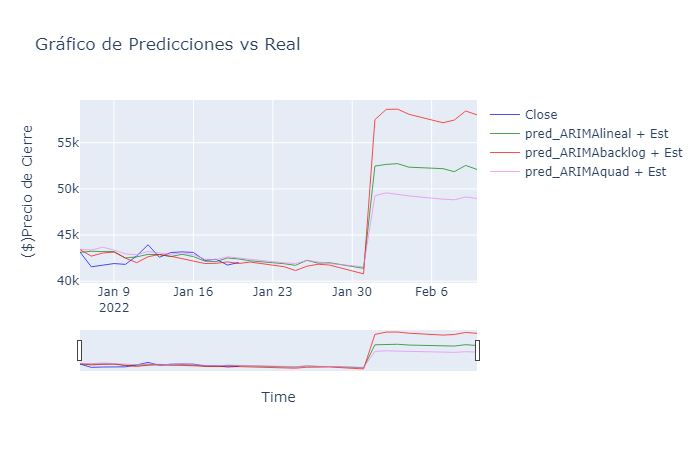

In [19]:
graficar_predicciones_arima(data[3])

<a id="4."></a> 
## 4 Future steps
<a href='#indice'>Back to Index</a>

'1. Use this function to recomend where to invest giving a list of finance assets

'2. Try to use this function to build an inversion bot function

'3. Deploy the final model in a web page or an API to use it online 